# Deep Learning Course
## Dense Neural Network hyperparameter tuning and Convolutional Network
### Dataset: Fashion MNIST [(Source: Zalando Research GitHub)](https://github.com/zalandoresearch/fashion-mnist)

**Hyperparameter tuning implementation for a Dense Neural Network on the Fashion MNIST dataset**

This implementation optimizes the hyperparameters of a dense neural network for classifying the Fashion MNIST dataset.
The optimization process is structured in sequential phases, allowing the identification of the optimal configuration.

**OPTIMIZATION PHASES**

1. **Optimizer and Learning Rate:** In this first phase, while keeping the basic architecture fixed (number of layers and moderate dimensions), we determine the optimal combination of optimizer and learning rate. This phase is prioritized as these parameters fundamentally influence model convergence.

2. **Number of layers:** Once the ideal optimizer is established, we evaluate the optimal number of layers, keeping their dimensions uniform. This phase determines the appropriate depth of the network for the specific problem.

3. **Width of layers:** With the optimal depth of the network already determined, we proceed to optimize the dimensions of each layer. This step defines the representational capacity of the network.

4. **Regularization techniques:** Finally, we explore various regularization strategies (Dropout, regularizers and batch) to improve the model's generalization and prevent overfitting.

This sequential approach is particularly effective because it allows isolating the effect of each group of hyperparameters, reducing the search space and facilitating the identification of the most promising configurations.

Additionally, it follows a logical order where fundamental learning parameters are optimized first, followed by the network structure, and finally the techniques to improve generalization.

After identifying the optimal parameters, we proceed to build the definitive dense neural network, which is validated on the validation set and finally evaluated on the test set.

Subsequently, to evaluate the benefits of specialized architectures for image data, a simple convolutional network will be implemented to compare its performance with the optimized dense neural network.

In [ ]:
# Libraries used

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf
import numpy as np
import os

The **Fashion MNIST** dataset is a collection of 70.000 fashion item images (60.000 for training and 10.000 for testing), divided in 10 different classes, with a size of 28x28 pixels.
<br/>
| Label | Class        | 
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     | 
| 2     | Pullover    | 
| 3     | Dress       | 
| 4     | Coat        | 
| 5     | Sandal      | 
| 6     | Shirt       | 
| 7     | Sneaker     |
| 8     | Bag         | 
| 9     | Ankle boot  |
 
<br/>

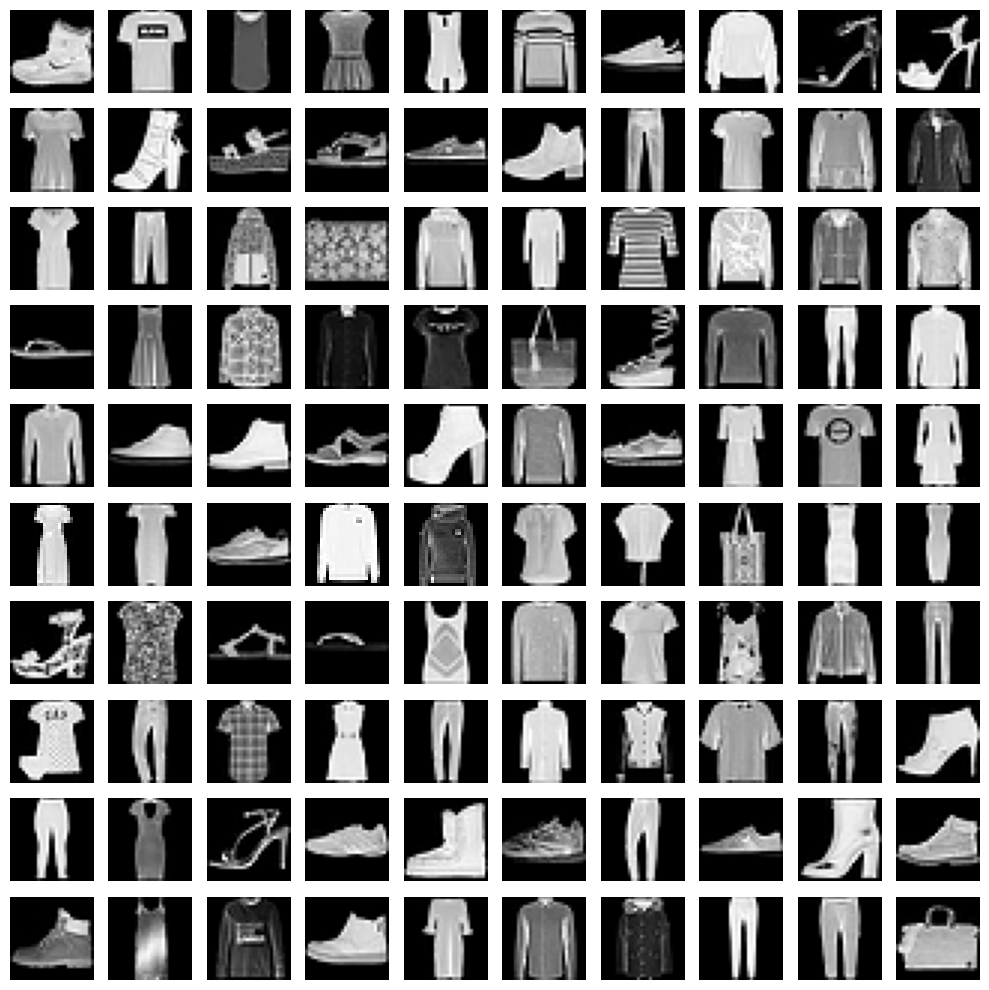

In [2]:
# Download fashion MNIST dataset and define train and test

fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Print some images

num_images = 100
rows = 10  
cols = 10

fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

for i in range(num_images):
    row = i // cols
    col = i % cols
    
    img = train_images[i]
    label = train_labels[i]
    
    axs[row, col].imshow(img, cmap="gray")
    axs[row, col].axis("off")

plt.tight_layout()
plt.show()

In [3]:
# Normalization and vectorization of the images

train_images = train_images/255.0
test_images = test_images/255.0

train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

print("Shape:")
print(f"    Training set -> {train_images.shape}")
print(f"    Test set     -> {test_images.shape}")

Shape:
    Training set -> (60000, 784)
    Test set     -> (10000, 784)


In [4]:
# train and validation split

x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=21)

In [ ]:
# First tuning: Optimizer and Learning Rate

def model_builder_1(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(x_train.shape[1],)))
    
    model.add(tf.keras.layers.Dense(units=128, 
                                    activation="relu"))
    model.add(tf.keras.layers.Dense(units=10, 
                                    activation="softmax"))
    
    hp_learning_rate = hp.Choice("lr", values=[1e-2, 1e-3, 1e-4])
    hp_optimizer = hp.Choice("opt", values=["adam", "sgd", "rmsprop"])
    
    if hp_optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
        
    elif hp_optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)
        
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    
    model.compile(optimizer=optimizer, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    
    return model

tuner_1 = kt.Hyperband(model_builder_1, 
                       objective="val_accuracy", 
                       max_epochs=50, 
                       directory="Tuning", 
                       project_name="Optimizer_and_Learning_Rate", 
                       hyperband_iterations=2)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                  patience = 5)

tuner_1.search(x_train, 
               y_train, 
               epochs=50, 
               validation_data=(x_val, y_val), 
               callbacks=[early_stopping])

best_hps_1 = tuner_1.get_best_hyperparameters(num_trials=1)[0]

print(f"Best learning rate: {best_hps_1.get('lr')}\nBest optimizer: {best_hps_1.get('opt')}")
print(f"Accuracy: {tuner_1.oracle.get_best_trials(1)[0].score}")

INFO:tensorflow:Reloading Tuner from Tuning\Optimizer_and_Learning_Rate\tuner0.json
INFO:tensorflow:Oracle triggered exit
Best learning rate: 0.001
Best optimizer: adam
Accuracy: 0.8723333477973938


In [ ]:
# Second Tuning: Layers number

def model_builder_2(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(x_train.shape[1],)))
    
    best_lr = best_hps_1.get("lr")
    best_opt = best_hps_1.get("opt")
    
    hp_num_layers = hp.Int("layers", min_value=1, max_value=5)
    
    for _ in range(hp_num_layers):
        model.add(tf.keras.layers.Dense(units=128, 
                                        activation="relu"))
    
    model.add(tf.keras.layers.Dense(units=10, 
                                    activation="softmax"))
    
    if best_opt == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)
    elif best_opt == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=best_lr)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=best_lr)
    
    model.compile(optimizer=optimizer, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    
    return model
    
tuner_2 = kt.Hyperband(model_builder_2, 
                       objective="val_accuracy", 
                       max_epochs=50, 
                       directory="Tuning", 
                       project_name="Layers", 
                       hyperband_iterations=2)

tuner_2.search(x_train, 
               y_train, 
               epochs=50, 
               validation_data=(x_val, y_val), 
               callbacks=[early_stopping])

best_hps_2 = tuner_2.get_best_hyperparameters(num_trials=1)[0]

print(f"Best number of layers: {best_hps_2.get('layers')}")
print(f"Accuracy: {tuner_2.oracle.get_best_trials(1)[0].score}")

INFO:tensorflow:Reloading Tuner from Tuning\Layers\tuner0.json
INFO:tensorflow:Oracle triggered exit
Best number of layers: 3
Accuracy: 0.8648333549499512


In [ ]:
# Third Tuning: Layers width

def model_builder_3(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(x_train.shape[1])))
    
    for i in range(best_hps_2.get("layers")):
        hp_units = hp.Choice(f"units_{i+1}", values=[32, 64, 128, 256, 512])
        model.add(tf.keras.layers.Dense(units=hp_units, 
                                        activation="relu"))
    
    model.add(tf.keras.layers.Dense(units=10, 
                                    activation="softmax"))
    
    best_lr = best_hps_1.get("lr")
    best_opt = best_hps_1.get("opt")
    
    if best_opt == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)
        
    elif best_opt == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=best_lr)
        
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=best_lr)
    
    model.compile(optimizer=optimizer, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    
    return model

tuner_3 = kt.Hyperband(model_builder_3, 
                       objective="val_accuracy", 
                       max_epochs=50, 
                       directory="Tuning", 
                       project_name="Units", 
                       hyperband_iterations=1)

tuner_3.search(x_train, 
               y_train, 
               epochs=50, 
               validation_data=(x_val, y_val), 
               callbacks=[early_stopping])

best_hps_3 = tuner_3.get_best_hyperparameters(num_trials=1)[0]

for i in range(best_hps_2.get("layers")):
    print(f"Best units for layer {i+1}: {best_hps_3.get(f'units_{i+1}')}")
print(f"Accuracy: {tuner_3.oracle.get_best_trials(1)[0].score}")


INFO:tensorflow:Reloading Tuner from Tuning\Units\tuner0.json
INFO:tensorflow:Oracle triggered exit
Best units for layer 1: 512
Best units for layer 2: 64
Best units for layer 3: 32
Accuracy: 0.8999999761581421


In [ ]:
# Fourth Tuning: Regularizer (Dropout, L1, L2, L1_L2)

def model_builder_4(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(x_train.shape[1])))
    
    for i in range(best_hps_2.get("layers")):
        regularizer = hp.Choice(f"regularizer_Layer_{i+1}", 
                                ["none", "l1", "l2", "l1_l2"])
        
        if regularizer == "l1":
            l1_value = hp.Choice(f"l1_Layer_{i+1}", 
                                 values=[1e-2, 1e-3, 1e-4])
            kernel_regularizer = tf.keras.regularizers.l1(l1_value)
            
        elif regularizer == "l2":
            l2_value = hp.Choice(f"l2_Layer_{i+1}", 
                                 values=[1e-2, 1e-3, 1e-4])
            kernel_regularizer = tf.keras.regularizers.l2(l2_value)
            
        elif regularizer =="l1_l2": 
            l1_value = hp.Choice(f"l1_Layer_{i+1}", 
                                 values=[1e-2, 1e-3, 1e-4])
            l2_value = hp.Choice(f"l2_Layer_{i+1}", 
                                 values=[1e-2, 1e-3, 1e-4])
            kernel_regularizer = tf.keras.regularizers.l1_l2(l1=l1_value, 
                                                             l2=l2_value)
        else:   
            kernel_regularizer = None
        
        model.add(tf.keras.layers.Dense(units=best_hps_3.get(f"units_{i+1}"), 
                                        activation="relu", 
                                        kernel_regularizer=kernel_regularizer))
        
        hp_use_dropout = hp.Boolean(f"dropout_Layer_{i+1}")
        if hp_use_dropout:
            dropout_rate = hp.Float(f"percentage_Layer_{i+1}", 0.1, 0.5, step=0.1)
            model.add(tf.keras.layers.Dropout(dropout_rate))
    
    model.add(tf.keras.layers.Dense(units=10, 
                                    activation="softmax"))
    
    best_lr = best_hps_1.get("lr")
    best_opt = best_hps_1.get("opt")
    
    if best_opt == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)
        
    elif best_opt == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=best_lr)
        
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=best_lr)
    
    model.compile(optimizer=optimizer, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    
    return model

tuner_4 = kt.Hyperband(model_builder_4, 
                       objective="val_accuracy", 
                       max_epochs=50, 
                       directory="Tuning", 
                       project_name="Regularizer", 
                       hyperband_iterations=1)

tuner_4.search(x_train, 
               y_train, 
               epochs=50, 
               validation_data=(x_val, y_val), 
               callbacks=[early_stopping])

best_hps_4 = tuner_4.get_best_hyperparameters(num_trials=1)[0]

for i in range(best_hps_2.get("layers")):
    print(f"Best regularizer for layer {i+1}: {best_hps_4.get(f'regularizer_Layer_{i+1}')}")
    
    if best_hps_4.get(f"regularizer_Layer_{i+1}") == "l1":
        l1_value = best_hps_4.get(f"l1_Layer_{i+1}")
        print(f"  Valore L1: {l1_value}")
        
    elif best_hps_4.get(f"regularizer_Layer_{i+1}") == "l2":
        l2_value = best_hps_4.get(f"l2_Layer_{i+1}")
        print(f"  Valore L2: {l2_value}")
        
    elif best_hps_4.get(f"regularizer_Layer_{i+1}") == "l1_l2":
        l1_value = best_hps_4.get(f"l1_Layer_{i+1}")
        l2_value = best_hps_4.get(f"l2_Layer_{i+1}")
        print(f"  Valore L1: {l1_value}")
        print(f"  Valore L2: {l2_value}")
        
    if best_hps_4.get(f"dropout_Layer_{i+1}"):
        print(f"Dropout = True: Percentage = {best_hps_4.get(f'percentage_Layer_{i+1}')}")
        
    else:
        print("Dropout = False")
        
print(f"Accuracy: {tuner_4.oracle.get_best_trials(1)[0].score}")

INFO:tensorflow:Reloading Tuner from Tuning\Regularizer\tuner0.json
INFO:tensorflow:Oracle triggered exit
Best regularizer for layer 1: none
Dropout = False
Best regularizer for layer 2: l2
  Valore L2: 0.0001
Dropout = True: Percentage = 0.4
Best regularizer for layer 3: l2
  Valore L2: 0.0001
Dropout = False
Accuracy: 0.8978333473205566


In [ ]:
# Building the final model from the tuning

final_model = tf.keras.Sequential(name="FINAL_MODEL")    

final_model.add(tf.keras.Input(shape=(x_train.shape[1])))
    
for layer in range(best_hps_2.get("layers")):
    if best_hps_4.get(f"regularizer_Layer_{layer+1}") == "l1":
        regularizer = tf.keras.regularizers.l1(best_hps_4.get(f"l1_Layer_{layer+1}"))
        
    elif best_hps_4.get(f"regularizer_Layer_{layer+1}") == "l2":
        regularizer = tf.keras.regularizers.l2(best_hps_4.get(f"l2_Layer_{layer+1}"))
        
    elif best_hps_4.get(f"regularizer_Layer_{layer+1}") == "l1_l2":
        regularizer = tf.keras.regularizers.l1_l2(best_hps_4.get(f"l1_Layer_{layer+1}"), 
                                                  best_hps_4.get(f"l2_Layer_{layer+1}"))
    else: 
        regularizer = None
    
    final_model.add(tf.keras.layers.Dense(units=best_hps_3.get(f"units_{layer+1}"),
                                          activation="relu",
                                          kernel_regularizer=regularizer,
                                          name=(f"Dense_{layer+1}")))
    
    if best_hps_4.get(f"dropout_Layer_{layer+1}"):
        final_model.add(tf.keras.layers.Dropout(best_hps_4.get(f"percentage_Layer_{layer+1}"),
                                                name= (f"Dropout_{layer+1}")))

final_model.add(tf.keras.layers.Dense(units=10, activation="softmax", name="Output"))

In [10]:
# Printing the summary

final_model.summary()

Model: "FINAL_MODEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 512)               401920    
                                                                 
 Dense_2 (Dense)             (None, 64)                32832     
                                                                 
 Dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 Dense_3 (Dense)             (None, 32)                2080      
                                                                 
 Output (Dense)              (None, 10)                330       
                                                                 
Total params: 437,162
Trainable params: 437,162
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Define Callbacks and compile

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience = 3,
                                                  restore_best_weights=True)

lr = best_hps_1.get("lr")

if best_hps_1.get("opt") == "adam":
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
elif best_hps_1.get("opt") == "sgd":
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    
elif best_hps_1.get("opt") == "rmsprop":
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)

final_model.compile(optimizer=optimizer,
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"])

In [12]:
# Directory for Models

dir = "Models"
path_dir = os.path.join(os.getcwd(), dir)

if not os.path.exists(path_dir):
    os.makedirs(path_dir)

In [13]:
# Best batch_size

initial_weights = final_model.get_weights()

batch_sizes = [32, 64, 128, 256, 512, 1024]
results = {}
histories = {}

for batch_size in batch_sizes:
    final_model.set_weights(initial_weights)
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f"Models/best_model_{batch_size}.keras",   
                                                    monitor="val_loss",    
                                                    save_best_only=True,        
                                                    mode="min",                 
                                                    verbose=1)
    
    histories[batch_size] = final_model.fit(x_train, 
                                            y_train, 
                                            epochs=50, 
                                            batch_size=batch_size, 
                                            validation_data=(x_val, y_val),
                                            callbacks=[checkpoint, early_stopping])

    val_loss, val_accuracy = final_model.evaluate(x_val, y_val)

    results[batch_size] = (val_loss, val_accuracy)

Epoch 1/50
1678/1688 [============================>.] - ETA: 0s - loss: 0.6220 - accuracy: 0.7848
Epoch 1: val_loss improved from inf to 0.41695, saving model to Models\best_model_32.keras
1688/1688 [==============================] - 8s 5ms/step - loss: 0.6213 - accuracy: 0.7850 - val_loss: 0.4169 - val_accuracy: 0.8525
Epoch 2/50
1680/1688 [============================>.] - ETA: 0s - loss: 0.4483 - accuracy: 0.8450
Epoch 2: val_loss improved from 0.41695 to 0.37766, saving model to Models\best_model_32.keras
1688/1688 [==============================] - 8s 5ms/step - loss: 0.4478 - accuracy: 0.8452 - val_loss: 0.3777 - val_accuracy: 0.8653
Epoch 3/50
1685/1688 [============================>.] - ETA: 0s - loss: 0.4037 - accuracy: 0.8602
Epoch 3: val_loss improved from 0.37766 to 0.35666, saving model to Models\best_model_32.keras
1688/1688 [==============================] - 8s 5ms/step - loss: 0.4037 - accuracy: 0.8603 - val_loss: 0.3567 - val_accuracy: 0.8743
Epoch 4/50
1680/1688 [====

In [14]:
# Results

print(f"{'Batch Size':^10} | {'Val Loss':^10} | {'Val Accuracy':^10}")
print("-" * 36)  

sorted_batch_sizes = sorted(batch_sizes, 
                            key=lambda x: results[x][1], 
                            reverse=True)

for batch_size in sorted_batch_sizes:
    print(f"{batch_size:^10} | {results[batch_size][0]:^10.4f} | {results[batch_size][1]:^10.4f}")

Batch Size |  Val Loss  | Val Accuracy
------------------------------------
   1024    |   0.3086   |   0.8918  
   512     |   0.3076   |   0.8905  
   128     |   0.3055   |   0.8902  
    64     |   0.3153   |   0.8882  
   256     |   0.3217   |   0.8837  
    32     |   0.3248   |   0.8818  


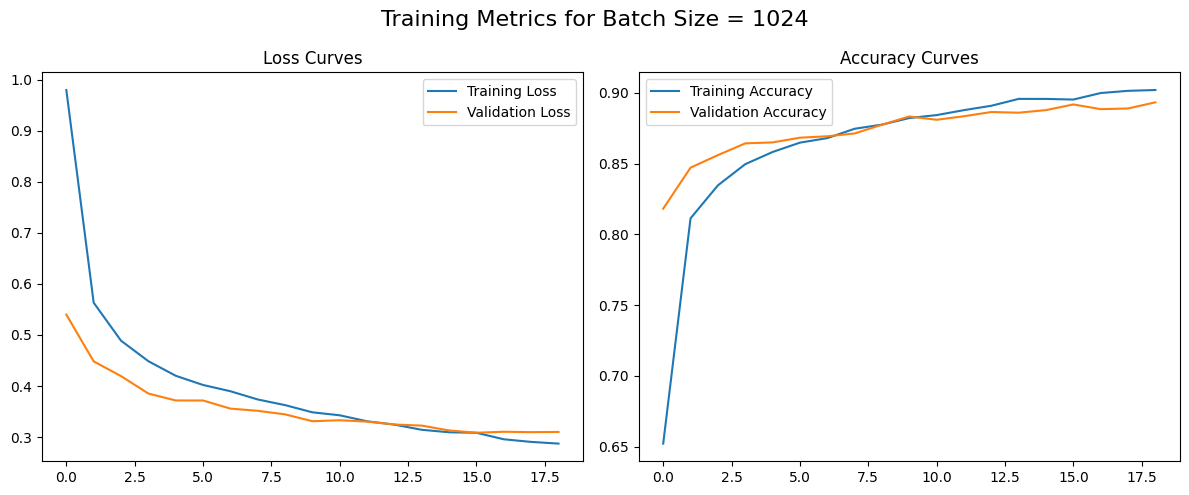

In [15]:
# Overfitting

batch_size = sorted_batch_sizes[0]

plt.figure(figsize=(12, 5))
plt.suptitle(f"Training Metrics for Batch Size = {batch_size}", fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(histories[batch_size].history["loss"], label="Training Loss")
plt.plot(histories[batch_size].history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1, 2, 2)
plt.plot(histories[batch_size].history["accuracy"], label="Training Accuracy")
plt.plot(histories[batch_size].history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curves")

plt.tight_layout()
plt.show()

In [16]:
# Re-training on training + validation

best_model = tf.keras.models.load_model(f"Models/best_model_{batch_size}.keras")

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="Models/best_dense_model.keras",
    monitor="loss",  
    save_best_only=True,
    mode="min",
    verbose=1
)

best_model.fit(
    train_images, 
    train_labels, 
    epochs=50,
    batch_size=batch_size,
    callbacks=[checkpoint]
)

predictions = best_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

Epoch 1/50
59/59 [==============================] - ETA: 0s - loss: 0.3012 - accuracy: 0.8989
Epoch 1: loss improved from inf to 0.30121, saving model to Models\best_dense_model.keras
59/59 [==============================] - 1s 12ms/step - loss: 0.3012 - accuracy: 0.8989
Epoch 2/50
56/59 [===========================>..] - ETA: 0s - loss: 0.2939 - accuracy: 0.9006
Epoch 2: loss improved from 0.30121 to 0.29358, saving model to Models\best_dense_model.keras
59/59 [==============================] - 1s 12ms/step - loss: 0.2936 - accuracy: 0.9007
Epoch 3/50
57/59 [===========================>..] - ETA: 0s - loss: 0.2866 - accuracy: 0.9028
Epoch 3: loss improved from 0.29358 to 0.28701, saving model to Models\best_dense_model.keras
59/59 [==============================] - 1s 11ms/step - loss: 0.2870 - accuracy: 0.9028
Epoch 4/50
56/59 [===========================>..] - ETA: 0s - loss: 0.2838 - accuracy: 0.9040
Epoch 4: loss improved from 0.28701 to 0.28365, saving model to Models\best_dense_

In [17]:
# Evaluation

print("Accuracy:", accuracy_score(test_labels, predicted_labels))

Accuracy: 0.8966


**Convolutional Network (Conv2D)**

We now implement a simple convolutional neural network to compare with the dense neural network.

In [18]:
# Download, standardization and split

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255

x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=21)

In [21]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(x_train.shape[1], 
                          x_train.shape[2], 
                          x_train.shape[3])),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=3, 
                           activation="relu"),
    
    tf.keras.layers.AveragePooling2D(pool_size=2),
    
    tf.keras.layers.Conv2D(filters=32, 
                           kernel_size=3, 
                           activation="relu"),
    
    tf.keras.layers.AveragePooling2D(pool_size=2),
    
    tf.keras.layers.Conv2D(filters=64, 
                           kernel_size=3, 
                           activation="relu"),
    
    tf.keras.layers.AveragePooling2D(pool_size=2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(units=10, 
                          activation="softmax")
])

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="Models/best_convolutional_model.keras",   
                                                monitor="val_loss",    
                                                save_best_only=True,        
                                                mode="min",                 
                                                verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience = 3,
                                                  restore_best_weights=True)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint, early_stopping])

val_loss, val_accuracy = model.evaluate(x_val, y_val)

print(f"Validation set accuracy ->: {val_accuracy:.4f}")

Epoch 1/30
210/211 [============================>.] - ETA: 0s - loss: 0.9126 - accuracy: 0.7266
Epoch 1: val_loss improved from inf to 0.39126, saving model to Models\best_convolutional_model.keras
211/211 [==============================] - 7s 30ms/step - loss: 0.9107 - accuracy: 0.7271 - val_loss: 0.3913 - val_accuracy: 0.8838
Epoch 2/30
211/211 [==============================] - ETA: 0s - loss: 0.2970 - accuracy: 0.9119
Epoch 2: val_loss improved from 0.39126 to 0.25612, saving model to Models\best_convolutional_model.keras
211/211 [==============================] - 6s 30ms/step - loss: 0.2970 - accuracy: 0.9119 - val_loss: 0.2561 - val_accuracy: 0.9247
Epoch 3/30
210/211 [============================>.] - ETA: 0s - loss: 0.2096 - accuracy: 0.9387
Epoch 3: val_loss improved from 0.25612 to 0.17113, saving model to Models\best_convolutional_model.keras
211/211 [==============================] - 6s 29ms/step - loss: 0.2096 - accuracy: 0.9386 - val_loss: 0.1711 - val_accuracy: 0.9482
Ep

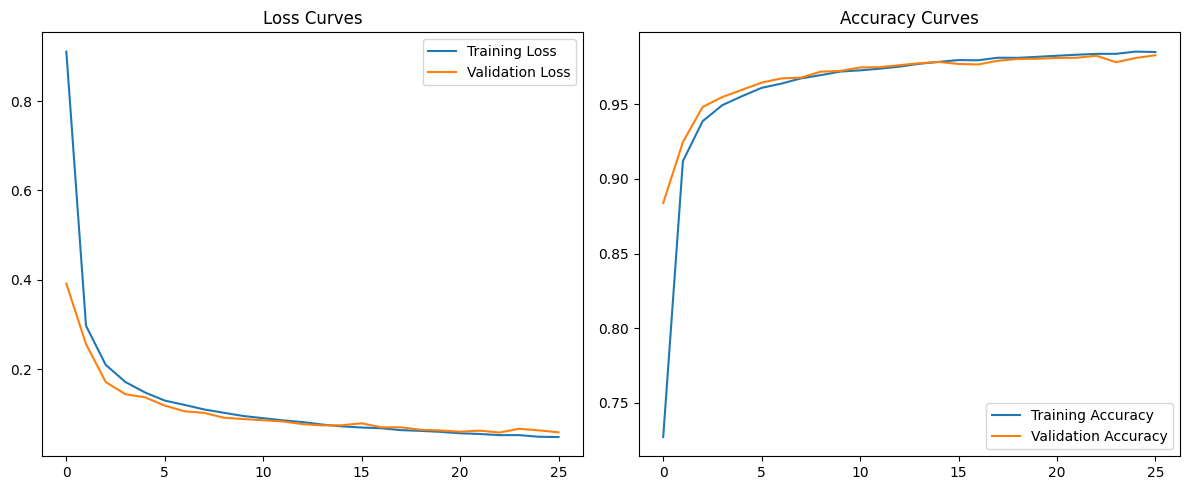

In [22]:
# Overfitting
 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curves")

plt.tight_layout()
plt.show()

In [ ]:
# Re-training on training + validation

best_model = tf.keras.models.load_model(f"Models/best_convolutional_model.keras")

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="Models/final_convolutional_model.keras",
    monitor="loss",  
    save_best_only=True,
    mode="min",
    verbose=1
)

best_model.fit(
    train_images, 
    train_labels, 
    epochs=30,
    batch_size=256,
    callbacks=[checkpoint]
)

prediction = best_model.predict(test_images)
predicted_labels = np.argmax(prediction, axis=1)

Epoch 1/30
233/235 [============================>.] - ETA: 0s - loss: 0.0530 - accuracy: 0.9838
Epoch 1: loss improved from inf to 0.05306, saving model to Models\final_convolutional_model.keras
235/235 [==============================] - 7s 28ms/step - loss: 0.0531 - accuracy: 0.9837
Epoch 2/30
233/235 [============================>.] - ETA: 0s - loss: 0.0519 - accuracy: 0.9839
Epoch 2: loss improved from 0.05306 to 0.05176, saving model to Models\final_convolutional_model.keras
235/235 [==============================] - 7s 28ms/step - loss: 0.0518 - accuracy: 0.9839
Epoch 3/30
233/235 [============================>.] - ETA: 0s - loss: 0.0491 - accuracy: 0.9858
Epoch 3: loss improved from 0.05176 to 0.04908, saving model to Models\final_convolutional_model.keras
235/235 [==============================] - 6s 28ms/step - loss: 0.0491 - accuracy: 0.9858
Epoch 4/30
234/235 [============================>.] - ETA: 0s - loss: 0.0461 - accuracy: 0.9860
Epoch 4: loss improved from 0.04908 to 0.

In [25]:
# Evaluation

print("Accuracy:", accuracy_score(test_labels, predicted_labels))

Accuracy: 0.9829


We can see how a simple convolutional neural network easily outperforms a dense neural network, even though the latter was optimized with hyperparameter tuning to achieve the best results.